# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [357]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [358]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import hex_to_pyvista, plot_grid, plot_grid_slice, plot_mesh, stop_grads_int

from tesseract_jax import apply_tesseract

In [7]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [50]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 128, 64, 64

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Lz - Lz / 2
    )


initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.01,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
    "sdf_backend": "pyvista",
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 360
Number of faces: 708
SDF shape: (128, 64, 64)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

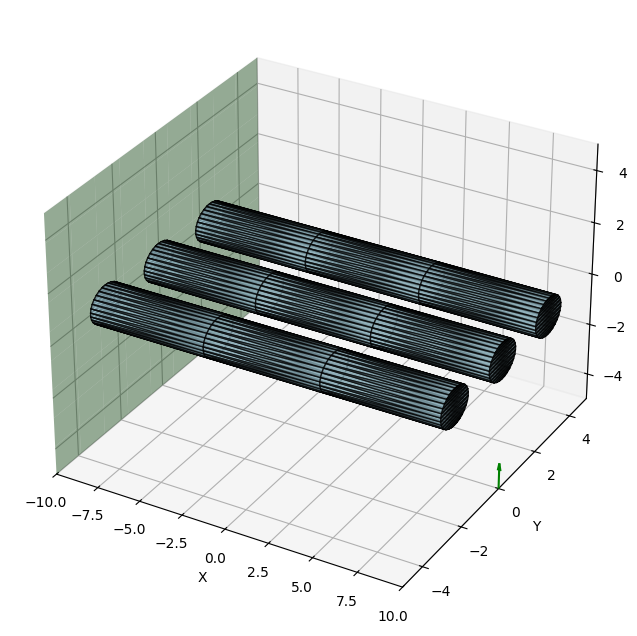

In [51]:
plot_mesh(mesh)

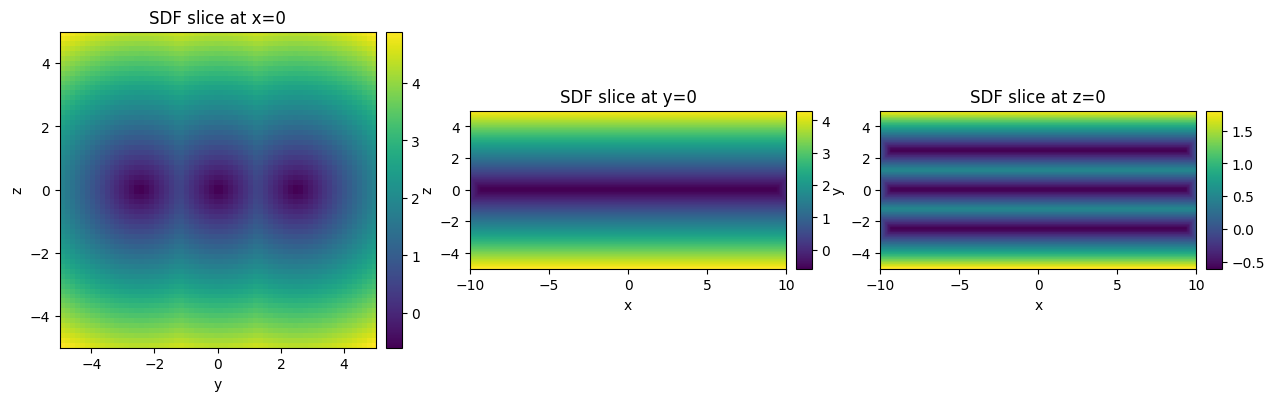

In [52]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [9]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, -1, 5)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]

#     design_inputs_eps = design_inputs.copy()
#     design_inputs_eps["epsilon"] = eps.item()

#     primal, vjp_fun = jax.vjp(
#         lambda params,  design_params=design_inputs_eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 **design_params,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [365]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

In [53]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Computing Jacobian...


In [47]:
print(initial_params)

[-1.         -0.25        0.         -0.33333328 -0.25        0.
  0.3333334  -0.25        0.          1.         -0.25        0.
 -1.          0.          0.         -0.33333328  0.          0.
  0.3333334   0.          0.          1.          0.          0.
 -1.          0.25        0.         -0.33333328  0.25        0.
  0.3333334   0.25        0.          1.          0.25        0.        ]


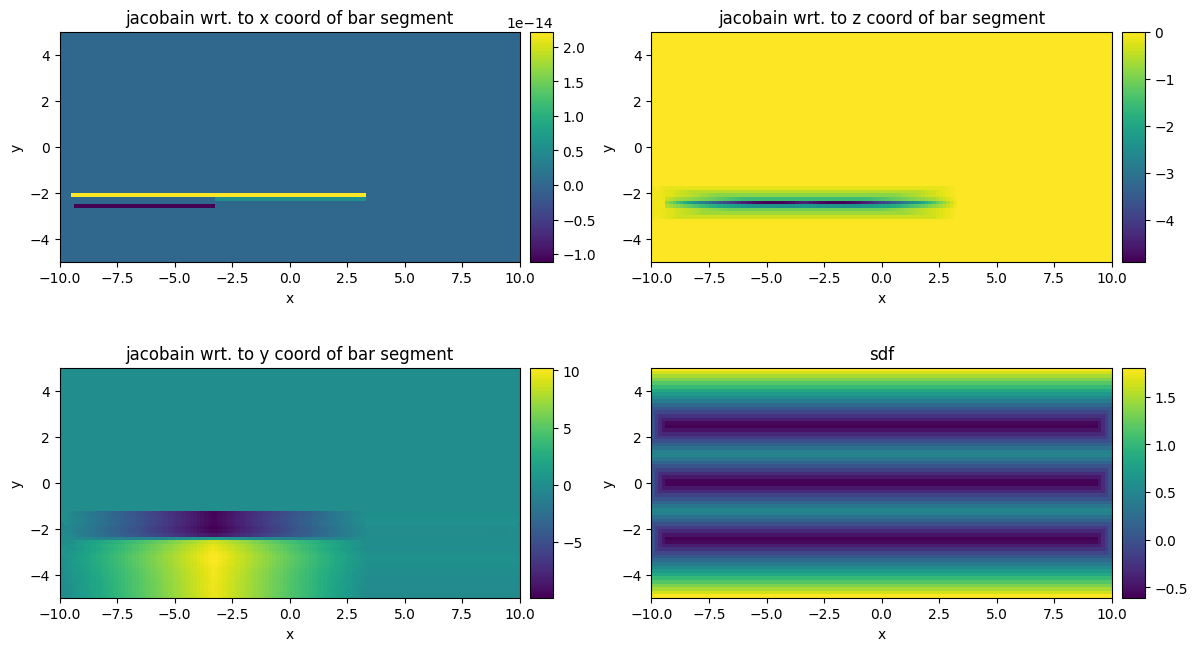

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][3][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to x coord of bar segment",
    xlabel="x",
    ylabel="y",
    log_scale=True,
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][4][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to y coord of bar segment",
    xlabel="x",
    ylabel="y",
    log_scale=True,
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][5][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to z coord of bar segment",
    xlabel="x",
    ylabel="y",
    log_scale=True,
)

plot_grid_slice(
    sdf[:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf",
    xlabel="x",
    ylabel="y",
    log_scale=True,
)

## Density and Sizing Field

rho min: 6.239625508897007e-05, rho max: 0.7883793115615845


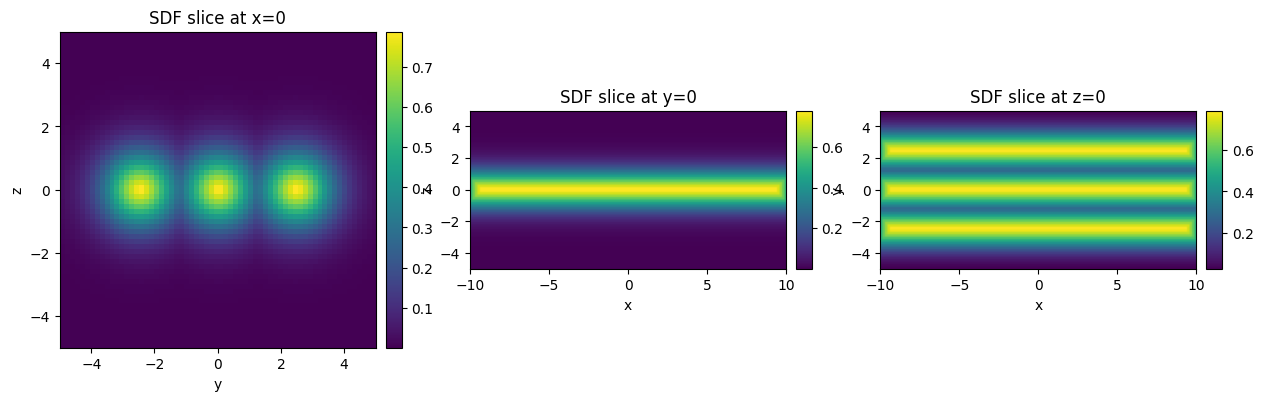

In [55]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


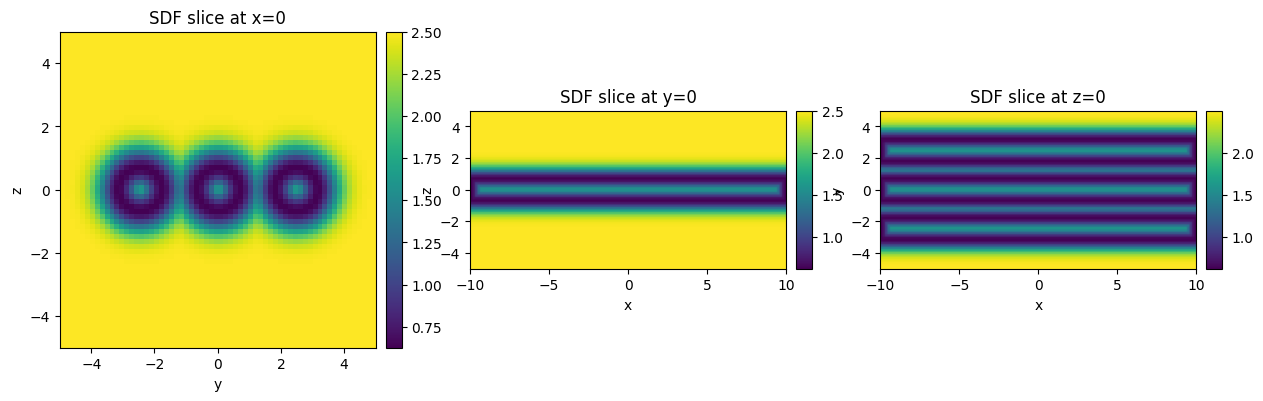

In [56]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [57]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Done building mesh
Mesh points: 10231, Mesh faces: 7952
0.7427368
(30000,)


Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [68]:
# Lets export it to a .vtk using pyvista
import numpy as np

# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"][: adaptive_mesh["n_points"]])
cells_np = np.array(adaptive_mesh["faces"][: adaptive_mesh["n_faces"]])

hex_mesh = hex_to_pyvista(
    pts_np,
    cells_np,
    {"rho": mesher_out["mesh_cell_values"][: adaptive_mesh["n_faces"]]},
)

print(hex_mesh)

hex_mesh.save("bars_mesh.vtk")

UnstructuredGrid (0x7b058372efe0)
  N Cells:    7952
  N Points:   10231
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


## Boundary Conditions

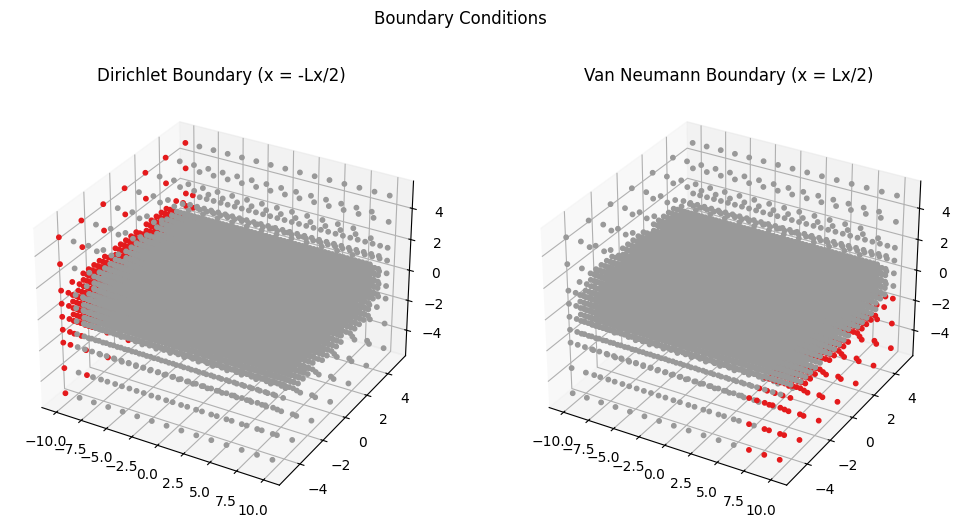

In [69]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [60]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



[11-24 22:35:41][INFO] jax_fem: pyamgx not installed. AMGX solver disabled.


In [375]:
# compliance = apply_tesseract(
#     fem_tess,
#     {
#         "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
#         "hex_mesh": adaptive_mesh,
#         "dirichlet_mask": dirichlet_mask,
#         "dirichlet_values": jnp.array([0.0]),
#         "van_neumann_mask": van_neumann_mask,
#         "van_neumann_values": jnp.array([[0.0, 0.0, 1.0]]),
#     },
# )["compliance"]
# print(f"Compliance: {compliance:.4f}")

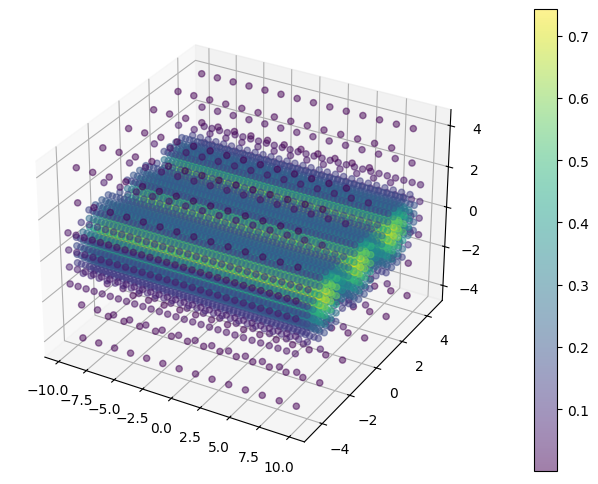

In [70]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [71]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [ ]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [73]:
grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [74]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

/anaconda/envs/fem/lib/python3.13/site-packages/numpy/_core/getlimits.py:559: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/anaconda/envs/fem/lib/python3.13/site-packages/numpy/_core/getlimits.py:91: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Done building mesh


[11-24 22:36:38][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 22:36:38][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 22:36:38][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-24 22:36:39][DEBUG] jax_fem: Done pre-computations, took 0.9884054660797119 [s]
[11-24 22:36:39][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-24 22:36:39][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 22:36:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 22:36:40][DEBUG] jax_fem: Start timing
[11-24 22:36:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 22:36:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.2753 seconds
[11-24 22:36:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 22:36:42][DEBUG] jax_fem: Before, l_2 res = 5.758367793509444, relative l_2 res

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
loss 37.82085418701172, grads [ 2.8390616e-02 -5.4311705e-01 -8.4920329e-01  1.1009032e-14
  3.4968203e-01 -1.0650580e+00  8.9805948e-16  1.3223257e+00
  9.5928168e-01 -2.9552151e-03  1.0024686e+00  2.9263663e+00
  3.2804079e-02 -1.9027188e-01 -7.2669172e-01 -2.6740203e-15
 -2.1005900e-01 -9.9816394e-01  2.9108939e-15 -6.7812584e-02
  2.2545218e-01 -1.7639282e-03 -4.6307284e-02  1.2234731e+00
  2.4325984e-02  5.0065640e-02 -7.7855802e-01  8.0519181e-15
 -7.8930628e-01 -9.8425651e-01  5.2148591e-15 -8.6605626e-01
  8.9207500e-01 -2.7274955e-03 -3.0473703e-01  2.7743521e+00]


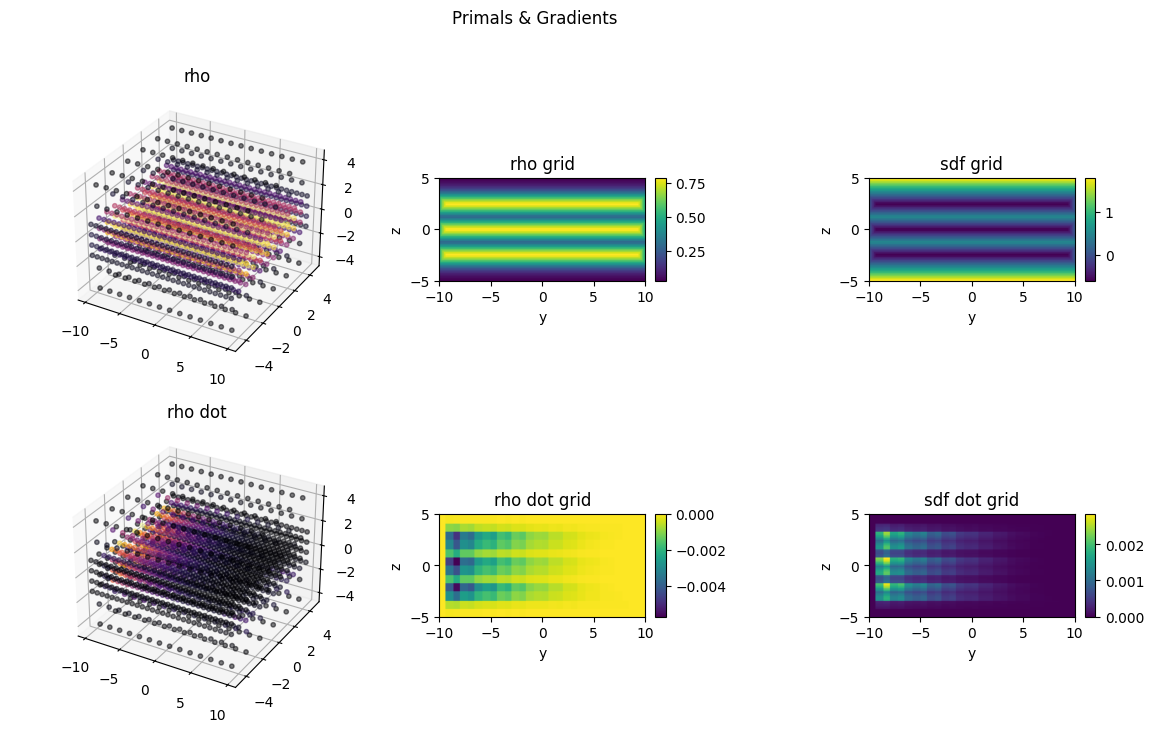

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = aux["hex_mesh"]

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=mesh["rho"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[3000][1][: mesh["rho"].shape[0]],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[2000][1][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[1000][1][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

In [78]:
print(grads)

[ 2.8390616e-02 -5.4311705e-01 -8.4920329e-01  1.1009032e-14
  3.4968203e-01 -1.0650580e+00  8.9805948e-16  1.3223257e+00
  9.5928168e-01 -2.9552151e-03  1.0024686e+00  2.9263663e+00
  3.2804079e-02 -1.9027188e-01 -7.2669172e-01 -2.6740203e-15
 -2.1005900e-01 -9.9816394e-01  2.9108939e-15 -6.7812584e-02
  2.2545218e-01 -1.7639282e-03 -4.6307284e-02  1.2234731e+00
  2.4325984e-02  5.0065640e-02 -7.7855802e-01  8.0519181e-15
 -7.8930628e-01 -9.8425651e-01  5.2148591e-15 -8.6605626e-01
  8.9207500e-01 -2.7274955e-03 -3.0473703e-01  2.7743521e+00]


In [ ]:
import optax

n_steps = 10
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.05, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    aux_hist.append(aux)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # # Ensure parameters are within bounds
    params = params.at[::3].set(initial_params.at[::3].get())

    # params = params.at[1::3].set(
    #     jnp.clip(params[1::3], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    # )

    # params = params.at[2::3].set(
    #     jnp.clip(params[2::3], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    # )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[11-24 15:00:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 15:00:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 15:00:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


Done building mesh


[11-24 15:00:53][DEBUG] jax_fem: Done pre-computations, took 0.3052694797515869 [s]
[11-24 15:00:53][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-24 15:00:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 15:00:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 15:00:53][DEBUG] jax_fem: Start timing
[11-24 15:00:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 15:00:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.1808 seconds
[11-24 15:00:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 15:00:54][DEBUG] jax_fem: Before, l_2 res = 5.289377788913166, relative l_2 res = 1.0
[11-24 15:00:54][DEBUG] jax_fem: Solving linear system...
[11-24 15:00:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 15:00:55][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.0881634389002407e-11
[11-24 15:00:55][DEBUG] j

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
[ 8.1995009e-03 -1.4682459e+00  1.1673398e+01 -4.0293950e-14
 -2.0087545e+00  8.0623789e+00 -6.7338137e-14  5.3158873e-01
 -2.8215365e+00 -1.7789345e-02  1.6359867e+00 -6.6627407e-01
  1.0638742e-03 -6.5047038e-01 -1.1294560e+00 -2.7752286e-14
 -8.0562341e-01 -4.9120154e+00 -2.2796730e-14 -6.8446875e-01
 -4.5007229e+00 -8.3433622e-03 -4.7027329e-01 -7.0393181e-01
  1.9924695e-02 -3.2898278e+00 -1.6613323e+01 -3.4916236e-14
 -3.7826898e+00 -1.7639462e+01 -5.6434756e-14 -1.5522267e+00
 -1.4260132e+00 -4.7459221e-04 -9.8127109e-01  5.0283492e-01]
[-1.          0.         -0.25       -0.33333328  0.         -0.25
  0.3333334   0.         -0.25        1.          0.         -0.25
 -1.          0.          0.         -0.33333328  0.          0.
  0.3333334   0.          0.          1.          0.          0.
 -1.          0.          0.25       -0.33333328  0.         

Text(0.5, 1.0, 'Compliance over Optimization')

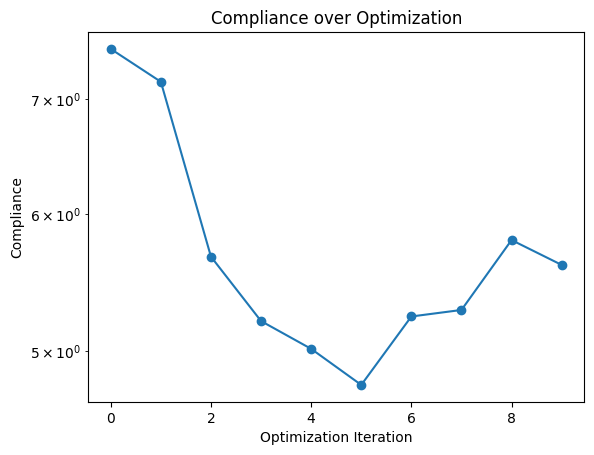

In [ ]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [31]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [2]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)

NameError: name 'params_hist' is not defined

In [382]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")